# 동식물 구별

-np.load 함수 사용을 위해 numpy 버전을 1.16.1로 함

In [ ]:
! pip install numpy==1.16.1

     |████████████████████████████████| 17.3MB 172kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir_ap = "/content/drive/My Drive/multi_img_data/imgs_others/train"
categories_ap = ["animals","plants"]
nb_classes_ap = len(categories_ap)

image_w_ap = 64
image_h_ap = 64

pixels_ap = image_h_ap * image_w_ap * 3

X_ap = []
y_ap = []

for idx, cat_ap in enumerate(categories_ap):
    
    #one-hot 돌리기.
    label_ap = [0 for i in range(nb_classes_ap)]
    label_ap[idx] = 1

    image_dir_ap = caltech_dir_ap + "/" + cat_ap
    files_ap = glob.glob(image_dir_ap+"/*.jpg")
    print(cat_ap, " 파일 길이 : ", len(files_ap))
    for i, f_ap in enumerate(files_ap):
        img_ap = Image.open(f_ap)
        img_ap = img_ap.convert("RGB")
        img_ap= img_ap.resize((image_w_ap, image_h_ap))
        data_ap = np.asarray(img_ap)

        X_ap.append(data_ap)
        y_ap.append(label_ap)

        if i % 700 == 0:
            print(cat_ap, " : ", f_ap)

X_ap = np.array(X_ap)
y_ap= np.array(y_ap)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(X_ap, y_ap)
xy_ap= (X_train_ap, X_test_ap, y_train_ap, y_test_ap)
np.save("/content/drive/My Drive/numpy_data/multi_image_data_AnP.npy", xy_ap)

print("ok", len(y_ap))

animals  파일 길이 :  108
animals  :  /content/drive/My Drive/multi_img_data/imgs_others/train/animals/elephant19.jpg
plants  파일 길이 :  108
plants  :  /content/drive/My Drive/multi_img_data/imgs_others/train/plants/forsythia1.jpg
ok 216


In [ ]:

import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config_ap = tf.ConfigProto()
config_ap.gpu_options.allow_growth = True
session = tf.Session(config=config_ap)

X_train_ap, X_test_ap, y_train_ap, y_test_ap = np.load('/content/drive/My Drive/numpy_data/multi_image_data_AnP.npy',allow_pickle=True)
print(X_train_ap.shape)
print(X_train_ap.shape[0])

(162, 64, 64, 3)
162


In [ ]:
categories_ap = ["animals","plants"]
nb_classes_ap = len(categories_ap)

#일반화
X_train_ap = X_train_ap.astype(float) / 255
X_test_ap = X_test_ap.astype(float) / 255

In [ ]:
with K.tf_ops.device('/device:GPU:0'):
    model_ap = Sequential()
    model_ap.add(Conv2D(32, (3,3), padding="same", input_shape=X_train_ap.shape[1:], activation='relu'))
    model_ap.add(MaxPooling2D(pool_size=(2,2)))
    model_ap.add(Dropout(0.25))
    
    model_ap.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model_ap.add(MaxPooling2D(pool_size=(2,2)))
    model_ap.add(Dropout(0.25))
    
    model_ap.add(Flatten())
    model_ap.add(Dense(256, activation='relu'))
    model_ap.add(Dropout(0.5))
    model_ap.add(Dense(nb_classes_ap, activation='softmax'))
    model_ap.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir_ap = './model'
    
    if not os.path.exists(model_dir_ap):
        os.mkdir(model_dir_ap)
    
    model_path_ap = model_dir_ap + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path_ap , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [ ]:
model_ap.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)            

In [ ]:
#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.

history_ap = model_ap.fit(X_train_ap, y_train_ap, batch_size=32, epochs=50, validation_data=(X_test_ap, y_test_ap), callbacks=[checkpoint, early_stopping])

Train on 162 samples, validate on 54 samples
Epoch 1/50
162/162 [==============================] - 1s 6ms/step - loss: 1.6911 - acc: 0.5062 - val_loss: 0.6788 - val_acc: 0.5185

Epoch 00001: val_loss improved from inf to 0.67882, saving model to ./model/multi_img_classification.model
Epoch 2/50
162/162 [==============================] - 0s 438us/step - loss: 0.7126 - acc: 0.5679 - val_loss: 0.6851 - val_acc: 0.6481

Epoch 00002: val_loss did not improve from 0.67882
Epoch 3/50
162/162 [==============================] - 0s 508us/step - loss: 0.6875 - acc: 0.5000 - val_loss: 0.6592 - val_acc: 0.5556

Epoch 00003: val_loss improved from 0.67882 to 0.65924, saving model to ./model/multi_img_classification.model
Epoch 4/50
162/162 [==============================] - 0s 476us/step - loss: 0.6431 - acc: 0.4753 - val_loss: 0.6554 - val_acc: 0.7963

Epoch 00004: val_loss improved from 0.65924 to 0.65538, saving model to ./model/multi_img_classification.model
Epoch 5/50
162/162 [=================

In [ ]:
print("정확도 : %.4f" % (model_ap.evaluate(X_test_ap, y_test_ap)[1]))


54/54 [==============================] - 0s 300us/step
정확도 : 0.9259


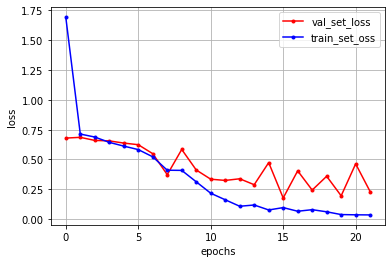

In [ ]:
y_vloss_ap = history_ap.history['val_loss']
y_loss_ap = history_ap.history['loss']

x_len_ap = np.arange(len(y_loss_ap))

plt.plot(x_len_ap, y_vloss_ap, marker='.', c='red', label='val_set_loss')
plt.plot(x_len_ap, y_loss_ap, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir_ap = "/content/drive/My Drive/multi_img_data/imgs_others_test"
image_w_ap = 64
image_h_ap = 64

pixels_ap = image_h_ap * image_w_ap * 3

X_ap = []
filenames_ap = []
files_ap = glob.glob(caltech_dir_ap+"/*.*")
for i, f_ap in enumerate(files_ap):
    img_ap = Image.open(f_ap)
    img_ap = img_ap.convert("RGB")
    img_ap= img_ap.resize((image_w_ap, image_h_ap))
    data_ap = np.asarray(img_ap)
    filenames_ap.append(f_ap)
    X_ap.append(data_ap)

X_ap = np.array(X_ap)
model_ap = load_model('./model/multi_img_classification.model')

prediction_ap = model_ap.predict(X_ap)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction_ap:
    pre_ans_ap = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans_ap)
    pre_ans_str_ap = ''
    if pre_ans_ap == 0: pre_ans_str_ap = "동물"
    else: pre_ans_str_ap = "식물"
    if i[0] >= 0.8 : print("해당 "+filenames_ap[cnt].split("\\")[0]+"이미지는 "+pre_ans_str_ap+"로 추정됩니다.")
    if i[1] >= 0.8 : print("해당 "+filenames_ap[cnt].split("\\")[0]+"이미지는 "+pre_ans_str_ap+"으로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_3.jpg이미지는 식물으로 추정됩니다.
[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_1.jpg이미지는 식물으로 추정됩니다.
[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_2.jpg이미지는 식물으로 추정됩니다.
[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_4.jpg이미지는 식물으로 추정됩니다.
[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_5.jpg이미지는 식물으로 추정됩니다.
[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_rose_1.jpg이미지는 식물으로 추정됩니다.
[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_rose_2.jpg이미지는 식물으로 추정됩니다.
[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_forsythia_1.jpg이미지는 식물으로 추정됩니다.
[0.000 1.000]
1
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_forsythia_2.jpg이미지는 식물으로 추정됩니다.
[0.000 

#동식물의 종류 구별

In [ ]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "/content/drive/My Drive/multi_img_data/imgs_others/train"
categories = ["rose", "forsythia", "lavender", "mugunghwa", "elephant", "tiger", "giraffe","rabbit"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("/content/drive/My Drive/numpy_data/multi_image_data.npy", xy)

print("ok", len(y))

rose  파일 길이 :  27
rose  :  /content/drive/My Drive/multi_img_data/imgs_others/train/rose/rose1.jpg
forsythia  파일 길이 :  27
forsythia  :  /content/drive/My Drive/multi_img_data/imgs_others/train/forsythia/forsythia1.jpg
lavender  파일 길이 :  27
lavender  :  /content/drive/My Drive/multi_img_data/imgs_others/train/lavender/lv1.jpg
mugunghwa  파일 길이 :  27
mugunghwa  :  /content/drive/My Drive/multi_img_data/imgs_others/train/mugunghwa/mugunghwa1.jpg
elephant  파일 길이 :  27
elephant  :  /content/drive/My Drive/multi_img_data/imgs_others/train/elephant/elephant1.jpg
tiger  파일 길이 :  27
tiger  :  /content/drive/My Drive/multi_img_data/imgs_others/train/tiger/tiger1.jpg
giraffe  파일 길이 :  27
giraffe  :  /content/drive/My Drive/multi_img_data/imgs_others/train/giraffe/giraffe22.jpg
rabbit  파일 길이 :  27
rabbit  :  /content/drive/My Drive/multi_img_data/imgs_others/train/rabbit/rabbit24.jpg
ok 216


In [ ]:

import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('/content/drive/My Drive/numpy_data/multi_image_data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(162, 64, 64, 3)
162


In [ ]:
categories = ["rose", "forsythia", "lavender", "mugunghwa", "elephant", "tiger", "giraffe", "rabbit"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [ ]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [ ]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)            

In [ ]:
#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.

history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 162 samples, validate on 54 samples
Epoch 1/50
162/162 [==============================] - 1s 7ms/step - loss: 3.6634 - acc: 0.1296 - val_loss: 2.0271 - val_acc: 0.1296

Epoch 00001: val_loss improved from inf to 2.02707, saving model to ./model/multi_img_classification.model
Epoch 2/50
162/162 [==============================] - 0s 426us/step - loss: 2.0863 - acc: 0.1975 - val_loss: 2.0367 - val_acc: 0.2778

Epoch 00002: val_loss did not improve from 2.02707
Epoch 3/50
162/162 [==============================] - 0s 505us/step - loss: 1.9921 - acc: 0.1420 - val_loss: 1.9565 - val_acc: 0.1296

Epoch 00003: val_loss improved from 2.02707 to 1.95651, saving model to ./model/multi_img_classification.model
Epoch 4/50
162/162 [==============================] - 0s 431us/step - loss: 1.8884 - acc: 0.1543 - val_loss: 1.8658 - val_acc: 0.3519

Epoch 00004: val_loss improved from 1.95651 to 1.86577, saving model to ./model/multi_img_classification.model
Epoch 5/50
162/162 [=================

In [ ]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))


54/54 [==============================] - 0s 290us/step
정확도 : 0.8519


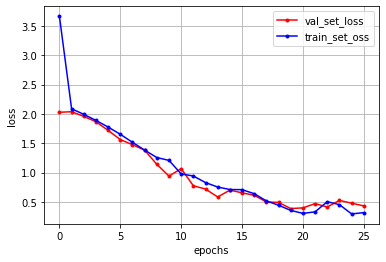

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "/content/drive/My Drive/multi_img_data/imgs_others_test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "장미"
    elif pre_ans == 1: pre_ans_str = "개나리"
    elif pre_ans == 2: pre_ans_str = "라벤더"
    elif pre_ans == 3: pre_ans_str = "무궁화"
    elif pre_ans == 4: pre_ans_str = "코끼리"
    elif pre_ans == 5: pre_ans_str = "호랑이"
    elif pre_ans == 6: pre_ans_str = "기린"
    else: pre_ans_str = "토끼"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 식물 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 식물 "+pre_ans_str+"로 추정됩니다.")
    if i[2] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 식물 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 식물 "+pre_ans_str+"로 추정됩니다.")
    if i[4] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 동물 "+pre_ans_str+"로 추정됩니다.")
    if i[5] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 동물 "+pre_ans_str+"로 추정됩니다.")
    if i[6] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 동물 "+pre_ans_str+"로 추정됩니다.")
    if i[7] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 동물 "+pre_ans_str+"로 추정됩니다.")    

    cnt += 1

    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

[0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]
2
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_3.jpg이미지는 식물 라벤더로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]
2
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_1.jpg이미지는 식물 라벤더로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]
2
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_2.jpg이미지는 식물 라벤더로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]
2
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_4.jpg이미지는 식물 라벤더로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]
2
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_lavender_5.jpg이미지는 식물 라벤더로 추정됩니다.
[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
0
해당 /content/drive/My Drive/multi_img_data/imgs_others_test/test_rose_1.jpg이미지는 식물 장미로 추정됩니다.
[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
0
해당 /content/drive/My Drive/multi_img_data/imgs_others